In [2]:
# load libs and modules
import numpy as np
import pandas as pd
import get_data
import preprocess_data

# for VIF
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# get data without location features for baseline models - use all years
train_df,test_df,validate_df = get_data.get_data('resale_price_norm',1990,2006,2007,2013,2014)

# get data with location features - shorter time frame (15 years - 441k data points)
# train_df,test_df,validate_df = get_data.get_data('resale_location_features',2007,2015,2016,2018,2019)

Getting Training Data
Training Data Done
Getting Test Data
Test Data Done
Getting Validation Data
Validation Data Done


In [7]:
one_hot_encode = ['town','flat_model']

train_df = preprocess_data.get_features_targets(train_df,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df,one_hot_encode)

## Check Correlations

- We use the traditional target of price per sq m normalized

In [8]:
combined = pd.concat([train_df,test_df,validate_df],ignore_index=True)

# check correlations to 
corr_df = combined.corr()
corr_df = corr_df[['price_per_sq_m_norm']].sort_values(by='price_per_sq_m_norm')
print(corr_df.to_string())

                                   price_per_sq_m_norm
town_woodlands                               -0.176522
town_jurong_west                             -0.160283
flat_model_new_generation                    -0.146223
town_yishun                                  -0.120810
town_bukit_panjang                           -0.074146
town_choa_chu_kang                           -0.073295
town_bukit_batok                             -0.068167
flat_model_simplified                        -0.063335
town_jurong_east                             -0.048254
town_sembawang                               -0.045680
flat_model_model_a                           -0.027387
flat_model_model_a2                          -0.022577
town_hougang                                 -0.020844
town_lim_chu_kang                            -0.019938
town_bedok                                   -0.005789
flat_model_adjoined_flat                     -0.002732
town_sengkang                                 0.004973
flat_model

Check correlations and multicollinearity before deciding what to drop

## Iteratively Check For Multicollinearity

In [18]:
# Iteratively check for Multicollinearity

# exclude target variables
targets = [ 'resale_price_norm',
            'price_per_sq_ft_norm',
            'price_per_sq_ft_per_lease_yr_norm',
            'price_per_sq_m_norm',
            'price_per_sq_m_per_lease_yr_norm',]

# get initial features 
features = [x for x in combined.columns.tolist() if x not in targets]


def calc_vif(df,list_of_features):
    '''
    Function to check for multicollinearity
    '''
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[list_of_features])
    headers = df[list_of_features].columns.tolist()
    df = pd.DataFrame(scaled_data, columns=headers)

    # create VIF dataframe
    vif_df = pd.DataFrame()
    vif_df['feature'] = list_of_features
    vif_df['VIF'] = [variance_inflation_factor(df[list_of_features].values,i) for i in range(len(list_of_features))]

    return vif_df.round(3).sort_values(by='VIF',ascending=False)

calc_vif(combined,features)
    

,feature,VIF
1,storey_range_max,2789.814
0,storey_range_min,1877.429
2,n_rooms,358.822
3,floor_area_sqm,282.472
4,remaining_lease_years,83.428
34,flat_model_improved,64.194
37,flat_model_model_a,60.177
41,flat_model_new_generation,57.395
45,flat_model_simplified,18.483
46,flat_model_standard,17.599


### Iteration 1: 
Slightly counter intutive but VIF suggests that we have to remove n_rooms and storey_range_max

In [19]:
features.remove('storey_range_max')
features.remove('n_rooms')
calc_vif(combined,features)

,feature,VIF
2,remaining_lease_years,82.698
1,floor_area_sqm,28.127
35,flat_model_model_a,27.868
32,flat_model_improved,27.576
39,flat_model_new_generation,22.778
43,flat_model_simplified,8.179
44,flat_model_standard,7.576
40,flat_model_premium_apartment,5.352
30,flat_model_apartment,3.667
0,storey_range_min,3.279


### Iteration 2:

VIF sugggests to drop remaining lease years as well - again slightly counter intutive but the intepretation is the flat_model and the town categories are sufficient to explain the age?

In [20]:
features.remove('remaining_lease_years')
calc_vif(combined,features)

,feature,VIF
1,floor_area_sqm,23.821
31,flat_model_improved,11.954
34,flat_model_model_a,11.261
38,flat_model_new_generation,8.560
43,flat_model_standard,4.529
42,flat_model_simplified,3.852
0,storey_range_min,3.280
39,flat_model_premium_apartment,2.838
24,town_tampines,2.389
20,town_queenstown,2.345


### Iteration 3:

Similarly size seems to also be explain by the flat_model and town. 

One way to look at it is that there are "periods" to building these flats - they typically launch flats of a specific type over a period of time in certain areas before opening new areas/new flat models. 

In [21]:
features.remove('floor_area_sqm')
calc_vif(combined,features)

,feature,VIF
33,flat_model_model_a,6.659
30,flat_model_improved,5.354
37,flat_model_new_generation,3.458
23,town_tampines,2.920
41,flat_model_simplified,2.646
26,town_yishun,2.482
13,town_jurong_west,2.441
25,town_woodlands,2.392
42,flat_model_standard,2.360
11,town_hougang,2.061


### Iteration 4:

We use 5 as our cut off which VIF suggest removing flat_model_model_a is the final iteration

In [22]:
features.remove('flat_model_model_a')
calc_vif(combined,features)

,feature,VIF
0,storey_range_min,1.799
30,flat_model_improved,1.629
41,flat_model_standard,1.564
36,flat_model_new_generation,1.548
19,town_queenstown,1.343
40,flat_model_simplified,1.279
37,flat_model_premium_apartment,1.250
1,town_bedok,1.247
26,town_yishun,1.216
10,town_geylang,1.192


### Iteration End

These features don't show a particularly high correlation to price per sq m but they seem to explain the variables we would expect to use:
- no or rooms
- size
- remaining lease years

For the next run, we should try a regression WITHOUT the categorical variables and compare model accuracies.

In [196]:
# import models to test
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def run_regression(defined_model, target, train_df,test_df,validate_df):

    # import preprocessing and evaluation metrics
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
    from yellowbrick.regressor import ResidualsPlot, PredictionError

    columns_to_drop = ['resale_price_norm',
                   'price_per_sq_ft_norm',
                   'price_per_sq_m_norm',
                   'price_per_sq_ft_per_lease_yr_norm',
                   'price_per_sq_m_per_lease_yr_norm',
                   'storey_range_max',
                   'n_rooms',
                   'remaining_lease_years',
                   'floor_area_sqm',
                   'flat_model_model_a'
                   ]
    targets = []
    targets.append(target)

    # get features and targets
    features = [x for x in train_df.columns.tolist() if x not in columns_to_drop]

    
    X_train = train_df[features]
    y_train = train_df[targets]
    X_test = test_df[features]
    y_test = test_df[targets]
    X_val = validate_df[features]
    y_val = validate_df[targets]

    # #scale and transform values
    # sc = MinMaxScaler()
    # X_train = sc.fit_transform(X_train)
    # X_test = sc.transform(X_test)
    # X_val = sc.transform(X_val)

    # fit and predict the model
    reg = defined_model
    reg.fit(X_train,y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    y_pred_val = reg.predict(X_val)

    # evaluate model
    # get R2 scores
    score_train = r2_score(y_train,y_pred_train)
    score_test = r2_score(y_test,y_pred_test)
    score_val = r2_score(y_val,y_pred_val)

    # get mse
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_test = mean_squared_error(y_test,y_pred_test)
    mse_val = mean_squared_error(y_val,y_pred_val)

    # print results
    r2_results = f'Dependent Variable:{target} \nR2 Scores: \nTrain:{score_train:.3f} \nTest:{score_test:.3f}\nValidation:{score_val:.3f}\nMSE: \nTrain:{mse_train:.3f} \nTest:{mse_test:.3f}\nValidation:{mse_val:.3f}\nIntercept:${reg.intercept_[0]:.2f}'
    print (r2_results)
    reg_coef = pd.DataFrame(reg.coef_,columns = features)
    


    # get residual plots
    model = defined_model
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()

    return reg_coef.T.round(3).sort_values(by=0,ascending=False)
    


In [1]:
# define some models
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
elastic = ElasticNet()

NameError: name 'LinearRegression' is not defined

### Run Regressions Against Different Target Variables

Dependent Variable:resale_price_norm 
R2 Scores: 
Train:0.510 
Test:0.142
Validation:0.200
MSE: 
Train:22789674301.903 
Test:16205701870.935
Validation:21892491108.388
Intercept:$463747.62


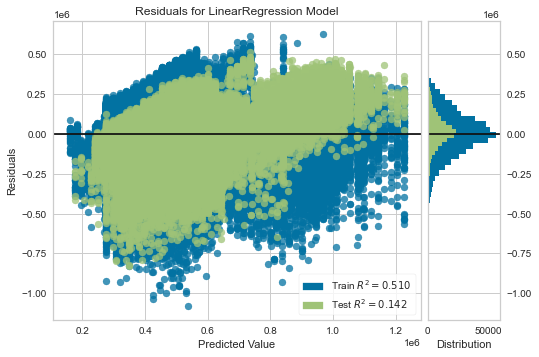

,0
flat_model_premium_maisonette,545771.238
flat_model_multi_generation,478140.703
flat_model_maisonette,435319.957
flat_model_terrace,434374.037
flat_model_apartment,389378.118
flat_model_model_a_maisonette,375506.932
flat_model_improved_maisonette,304854.379
flat_model_adjoined_flat,174321.740
town_bishan,172562.065
town_bukit_timah,106689.693


In [187]:
run_regression(lr,'resale_price_norm',train_df,test_df,validate_df)

Dependent Variable:price_per_sq_m_norm 
R2 Scores: 
Train:0.356 
Test:0.097
Validation:0.250
MSE: 
Train:748756.791 
Test:827028.848
Validation:1279405.156
Intercept:$4889.19


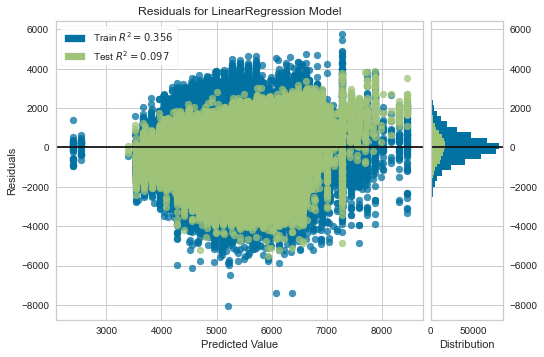

,0
flat_model_terrace,2315.107
flat_model_premium_maisonette,1624.592
flat_model_maisonette,1322.941
town_bishan,1188.929
flat_model_apartment,1176.004
town_marine_parade,1114.896
flat_model_multi_generation,1076.615
flat_model_model_a_maisonette,1020.332
flat_model_improved_maisonette,935.933
town_bukit_timah,854.511


In [188]:
run_regression(lr,'price_per_sq_m_norm',train_df,test_df,validate_df)

Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.378 
Test:0.145
Validation:-0.015
MSE: 
Train:105.679 
Test:240.253
Validation:372.367
Intercept:$58.48


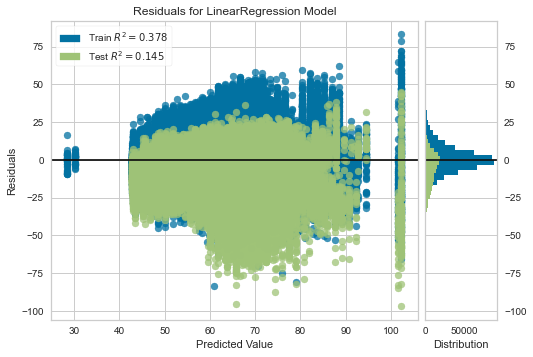

,0
flat_model_terrace,41.712
town_marine_parade,18.604
flat_model_premium_maisonette,14.747
flat_model_improved_maisonette,14.291
flat_model_maisonette,14.276
flat_model_multi_generation,12.184
flat_model_model_a_maisonette,11.708
flat_model_apartment,11.582
town_bishan,9.821
town_bukit_timah,9.798


In [189]:
run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,test_df,validate_df)